# HW 4 - Part2 : GANs 

In this homework you will build a deep generative model of binary images (MNIST) using variational autoencoders and generative adversarial networks.
The original VAE paper can be found [here](https://arxiv.org/abs/1312.6114) and GANs [here](https://arxiv.org/abs/1406.2661), and there are many excellent tutorials
online, e.g. [here](https://arxiv.org/abs/1606.05908) and [here](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

**For this homework there will not be a Kaggle submission**

## Goals


1. Build a discrete deep generative model of binary digits (MNIST) using variational autoencoders
2. Examine the learned latent space with visualizations 
3. Build a conditinous deep geneartive model using generative adversarial networks.
4. Additionally extend the above in any way, for example by :
    - using better encoder/decoders (e.g. CNN as the encoder, PixelCNN as the decoder. Description of PixelCNN 
    can be found [here](https://arxiv.org/abs/1601.06759))
    - using different variational families, e.g. with [normalizing flows](https://arxiv.org/abs/1505.05770), 
    [inverse autoregressive flows](https://arxiv.org/pdf/1606.04934.pdf), 
    [hierarchical models](https://arxiv.org/pdf/1602.02282.pdf)
    - comparing with stochastic variational inference (i.e. where your variational parameters are randomly initialized and
    then updated with gradient ascent on the ELBO
    - or your own extension.

For your encoder/decoder, we suggest starting off with simple models (e.g. 2-layer MLP with ReLUs).

Consult the papers provided for hyperparameters, and the course notes for formal definitions.


## Setup

This notebook provides a working definition of the setup of the problem itself. Feel free to construct your models inline, or use an external setup (preferred) to build your system.

First, as always, let's download the data.

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
train_dataset = datasets.MNIST(root='./data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = datasets.MNIST(root='./data/',
                           train=False, 
                           transform=transforms.ToTensor())

In [ ]:
print(len(train_dataset))
print(len(test_dataset))
train_dataset[0][0]

By default MNIST gives grayscale values between [0,1]. Since we are modeling binary images, we have to turn these
into binary values, i.e. $\{0,1\}^{784}$). A standard way to do this is to interpret the grayscale values as 
probabilities and sample Bernoulli random vectors based on these probabilities. (Note you should not do this for GANs)


In [ ]:
torch.manual_seed(3435)
train_img = torch.stack([torch.bernoulli(d[0]) for d in train_dataset])
train_label = torch.LongTensor([d[1] for d in train_dataset])
test_img = torch.stack([torch.bernoulli(d[0]) for d in test_dataset])
test_label = torch.LongTensor([d[1] for d in test_dataset])
print(train_img[0])
print(train_img.size(), train_label.size(), test_img.size(), test_label.size())
                        

MNIST does not have an official train dataset. So we will use the last 10000 training points as your validation set.

In [ ]:
val_img = train_img[-10000:].clone()
val_label = train_label[-10000:].clone()
train_img = train_img[:10000]
train_label = train_label[:10000]

Now we use the dataloader to split into batches.

In [ ]:
train = torch.utils.data.TensorDataset(train_img, train_label)
val = torch.utils.data.TensorDataset(val_img, val_label)
test = torch.utils.data.TensorDataset(test_img, test_label)
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
for datum in train_loader:
    img, label = datum
    print(img.size(), label.size())
    break

Great now we are ready to begin modeling. Performance-wise, you want tune your hyperparameters based on the **evidence lower bound (ELBO)**. Recall that the ELBO is given by:

$$ELBO = \mathbb{E}_{q(\mathbf{z} ; \lambda)} [\log p(\mathbf{x} \,|\,\mathbf{z} ; \theta)] - \mathbb{KL}[q(\mathbf{z};\lambda) \, \Vert \, p(\mathbf{z})]$$

The variational parameters are given by running the encoder over the input, i..e. $\lambda = encoder(\mathbf{x};\phi)$. The generative model (i.e. decoder) is parameterized by $\theta$. Since we are working with binarized digits, $\log p(x \, | \, \mathbf{z} ; \theta)$ is given by:

$$ \log p(x \, | \, \mathbf{z} ; \theta) = \sum_{i=1}^{784} \log \sigma(\mathbf{h})_{i} $$

where $\mathbf{h}$ is the final layer of the generative model (i.e. 28*28 = 784 dimensionval vector), and $\sigma(\cdot)$ is the sigmoid function. 

For the baseline model in this assignment you will be using a spherical normal prior, i.e. $p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$. The variational family will also be normal, i.e. $q(\mathbf{z} ; \lambda) = \mathcal{N}(\boldsymbol{\mu}, \log \boldsymbol \sigma^2)$ (here we will work with normal families with diagonal covariance). The KL-divergence between the variational posterior $q(\mathbf{z})$ and the prior $p(\mathbf{z})$ has a closed-form analytic solution, which is available in the original VAE paper referenced above. (If you are using the torch distributions package they will automatically calculate it for you, however you will need to use pytorch 0.4).

# Question 3: Baseline GAN

## Set up 

In [67]:
import torch
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as img_utils

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_dataset = datasets.MNIST(root='./data/',
                            train=True, 
                            transform=transform,
                            download=True)
test_dataset = datasets.MNIST(root='./data/',
                           train=False, 
                           transform=transform)

In [68]:
torch.manual_seed(3435)
train_img = torch.stack([d[0] for d in train_dataset])
train_label = torch.LongTensor([d[1] for d in train_dataset])
test_img = torch.stack([d[0] for d in test_dataset])
test_label = torch.LongTensor([d[1] for d in test_dataset])
print(train_img.size(), train_label.size(), test_img.size(), test_label.size())

torch.Size([60000, 1, 28, 28]) torch.Size([60000]) torch.Size([10000, 1, 28, 28]) torch.Size([10000])


In [69]:
val_img = train_img[-10000:].clone()
val_label = train_label[-10000:].clone()
train_img = train_img[:10000]
train_label = train_label[:10000]
train = torch.utils.data.TensorDataset(train_img, train_label)
val = torch.utils.data.TensorDataset(val_img, val_label)
test = torch.utils.data.TensorDataset(test_img, test_label)
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
print(train_loader)

torch.Size([100, 1, 28, 28]) torch.Size([100])
torch.Size([28, 28])


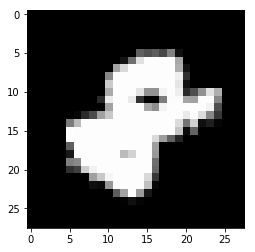

In [72]:
for datum in train_loader:
    img, label = datum
    print(img.size(), label.size())
    print(img[3][0].shape)
    plt.imshow(img[3][0], cmap='gray')
    plt.show()
    break

## Model

In [73]:
import torch
import torch.nn as nn
import numpy as np 
from torch.autograd import Variable as V
import torch.nn.functional as F
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import matplotlib.patches as patches

In [74]:
LATENT_DIM = 64
class Generator(nn.Module):
    def __init__(self, output_size=28*28):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(LATENT_DIM, 100)
        self.linear2 = nn.Linear(100, output_size)
        
    def forward(self, z):
        return F.tanh(self.linear2(F.relu(self.linear1(z))))
    
class Discriminator(nn.Module):
    def __init__(self, output_size=28*28):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(output_size, 100)
        self.linear2 = nn.Linear(100, 1)

    def forward(self, point):
        return F.sigmoid(self.linear2(F.relu(self.linear1(point))))

In [86]:
G = Generator()
D = Discriminator()
learning_rate = 0.01
optim_gen = torch.optim.SGD(G.parameters(), lr=learning_rate)
optim_disc = torch.optim.SGD(D.parameters(), lr=learning_rate)
seed_distribution = Normal(V(torch.zeros(BATCH_SIZE, LATENT_DIM)), 
                           V(torch.ones(BATCH_SIZE, LATENT_DIM)))       

In [87]:
NUM_EPOCHS = 100
output_arr = torch.zeros((NUM_EPOCHS, 1, 28, 28))
gen_loss = [] 
disc_loss = [] 
for epoch in range(NUM_EPOCHS):
    total_gen_loss = 0
    total_disc_loss = 0
    num_batches = 0 
    for datum in train_loader:
        img, label = datum
        
        # Grad real
        # -E[log(D(x))]
        optim_disc.zero_grad()
        optim_gen.zero_grad()
        x_real = V(img).view(-1, 784)
        d = D(x_real)
        loss_a = 0.5 * -d.log().mean()
        loss_a.backward()
        
        # Grad fake
        # -E[log(1 - D(G(z)) )]
        seed = seed_distribution.sample()
        x_fake = G(seed)
    
        d = D(x_fake.detach())        
        loss_b = 0.5 * -(1 - d + 1e-10).log().mean()
        loss_b.backward()
        optim_disc.step()
        total_disc_loss += loss_a.data[0] + loss_b.data[0]

        # Grad generator
        # E[log(1 - D(G(z)))]
        optim_disc.zero_grad()
        # No detach here.
        d = D(x_fake)
        loss_c = (1 - d + 1e-10).log().mean()
        #loss_c = -(d + 1e-10).log().mean()
        loss_c.backward()        
        optim_gen.step()    
        total_gen_loss += loss_c.data[0]
        
        num_batches += 1 
    
    #show fake 
    disp_arr = x_fake.detach()[0]
    output_arr[epoch] = disp_arr.view(1, 28, 28)
    disc_loss.append(float(total_disc_loss[0]))
    gen_loss.append(float(total_gen_loss[0]))
    if epoch % 10 == 0: 
        print(epoch, total_disc_loss[0] /  num_batches, total_gen_loss[0] / num_batches)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use

0 
 0.3267
[torch.FloatTensor of size ()]
 
-0.5671
[torch.FloatTensor of size ()]

10 
 0.1175
[torch.FloatTensor of size ()]
 
-0.2105
[torch.FloatTensor of size ()]

20 
1.00000e-02 *
  5.1377
[torch.FloatTensor of size ()]
 
1.00000e-02 *
 -8.2801
[torch.FloatTensor of size ()]

30 
1.00000e-02 *
  3.2730
[torch.FloatTensor of size ()]
 
1.00000e-02 *
 -4.8509
[torch.FloatTensor of size ()]

40 
1.00000e-02 *
  4.0920
[torch.FloatTensor of size ()]
 
1.00000e-02 *
 -5.5316
[torch.FloatTensor of size ()]

50 
 0.3914
[torch.FloatTensor of size ()]
 
-0.5646
[torch.FloatTensor of size ()]

60 
 0.2403
[torch.FloatTensor of size ()]
 
-0.2465
[torch.FloatTensor of size ()]

70 
1.00000e-02 *
  7.8890
[torch.FloatTensor of size ()]
 
1.00000e-02 *
 -7.6559
[torch.FloatTensor of size ()]

80 
1.00000e-02 *
  5.5928
[torch.FloatTensor of size ()]
 
1.00000e-02 *
 -5.3605
[torch.FloatTensor of size ()]

90 
1.00000e-02 *
  5.0132
[torch.FloatTensor of size ()]
 
1.00000e-02 *
 -4.7763
[to

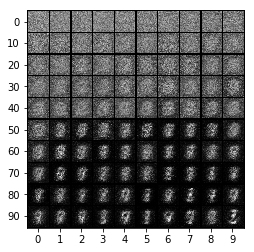

In [88]:
plt.yticks(np.arange(15,10*30+15,30), ('0', '10', '20', '30', '40', '50', '60', '70', '80', '90' ))
plt.xticks(np.arange(15,10*30+15,30), ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9' ))
show(output_arr)

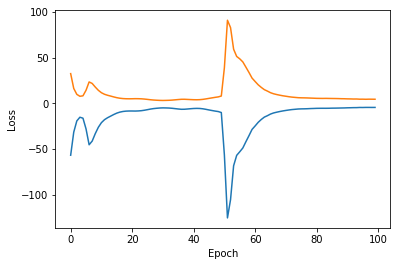

In [89]:
plt.plot(range(NUM_EPOCHS), gen_loss, label ='generator loss')
plt.plot(range(NUM_EPOCHS), disc_loss, label ='discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()